# A Tour of Pytorch Fully Sharded Data Parallel (FSDP)

In [2]:
import torch

print('Pytorch version\t:', torch.__version__)
print('CUDA version\t:', torch.version.cuda)

for i in range(torch.cuda.device_count()):
    print(f'GPU{i}\t\t:',torch.cuda.get_device_name(i))

Pytorch version	: 2.1.0.dev20230727+cu118
CUDA version	: 11.8
GPU0		: NVIDIA GeForce RTX 3090
GPU1		: NVIDIA GeForce RTX 3090
GPU2		: NVIDIA GeForce RTX 3090
GPU3		: NVIDIA GeForce RTX 3090
GPU4		: NVIDIA GeForce RTX 3090
GPU5		: NVIDIA GeForce RTX 3090
GPU6		: NVIDIA GeForce RTX 3090
GPU7		: NVIDIA GeForce RTX 3090


In [3]:
import inspect
from collections import defaultdict
import pandas as pd
from torch.utils import benchmark 

pd.options.display.precision = 3

def var_dict(*args):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return dict([
        (name, val)
        for name, val in callers_local_vars
        if val is arg][0] 
        for arg in args)

def walltime(stmt, arg_dict, duration=3):
    return benchmark.Timer(stmt=stmt, globals=arg_dict).blocked_autorange(
        min_run_time=duration).median

Matrix multiplaction TFLOPS benchmark ported from [mli/transformers-benchmarks](https://github.com/mli/transformers-benchmarks/).

In [5]:
matmul_tflops = defaultdict(lambda: {})
for n in [128, 512, 2048, 8192]:
    for dtype in (torch.float32, torch.float16, torch.bfloat16):
        a = torch.randn(n, n, dtype=dtype).cuda()
        b = torch.randn(n, n, dtype=dtype).cuda()   
        t = walltime('a @ b', var_dict(a, b))
        matmul_tflops[f'n={n}'][dtype] = 2*n**3 / t / 1e12
        del a, b
        
pd.DataFrame(matmul_tflops)

,n=128,n=512,n=2048,n=8192
torch.float32,0.431,11.451,21.033,23.802
torch.float16,0.316,25.121,62.724,67.092
torch.bfloat16,0.415,25.882,63.540,71.375


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from IPython.display import clear_output

SOURCE = '/workspace/test_peft/tour_fsdp/main.py'

@dataclass
class Exp:
    name: str
    workspace: str
    num_gpus: int
    micro_batch_size: int
    sequence_length: int
    gradient_accumulation_steps: int
    use_lora: bool = False
    cpu_offload: bool = False
    forward_prefetch: bool = False
    backward_prefetch: bool = False
    limit_all_gathers: bool = False
    activation_checkpoint: bool = False
    model: str = '7B'
    # Results
    time: int = None
    tflops: float = None
    model_memory: int = None
    running_memory: int = None

    def run(self):
        if self.num_gpus > 1:
            launcher = f'torchrun --nproc_per_node {self.num_gpus} '
        else:
            launcher = 'python'
        visible_devices = ','.join(map(str, range(self.num_gpus)))
        cmd = [
            'PYTHONPATH=/workspace/test_peft/tour_fsdp/',
            f'CUDA_VISIBLE_DEVICES={visible_devices}',
            f'{launcher} {SOURCE}',
            f'{self.workspace}',
            f'--model {self.model}',
            f'--gradient-accumulation-steps',
            f'{self.gradient_accumulation_steps}',
            f'--micro-batch-size {self.micro_batch_size}',
            f'--sequence-length {self.sequence_length}',
        ]
        if self.use_lora:
            cmd.append('--use-lora')
        if self.activation_checkpoint:
            cmd.append('--enable-activation-checkpointing')
        if self.cpu_offload:
            cmd.append('--cpu-offload')
        if self.forward_prefetch:
            cmd.append('--forward-prefetch')
        if self.backward_prefetch:
            cmd.append('--backward-prefetch')
        if self.limit_all_gathers:
            cmd.append('--limit-all-gathers')
        if self.num_gpus > 1:
            cmd.append('--enable-fsdp')
        # cmd.append('2>/dev/null')

        cmd = ' '.join(cmd)
        print(cmd, flush=True)

        if not os.path.exists(self.workspace):
            os.system(cmd)
        # os.system(cmd)

        # Gather info from logs
        res = 0.
        try:
            for gpu in range(self.num_gpus):
                with open(self.workspace + f'/log.{gpu}', 'r') as f:
                    res += extract_numbers(f.read())
            res /= self.num_gpus
            model_mem, running_mem, time, tflops = res

            self.model_memory = model_mem
            self.running_memory = running_mem
            self.time = time
            self.tflops = tflops
        except Exception as e:
            self.model_memory = float('nan')
            self.running_memory = float('nan')
            self.time = float('nan')
            self.tflops = float('nan')
            print(e)

    def print_metric(self):
        print(self.name)
        print('GPU memory for model only: {} MB'.format(
            self.model_memory // 1024 // 1024))
        print('Peak GPU memory: {} MB'.format(
            self.running_memory // 1024 // 1024))
        print(f'Total time: {self.time} s')
        print(f'TFLOPS: {self.tflops}', flush=True)

    def __post__init__(self):
        self.workspace = str(self.workspacek)


def extract_numbers(text):
    numbers = []
    for word in text.split():
        try:
            number = float(word.replace(',', ''))
            numbers.append(number)
        except ValueError:
            pass
    return np.array(numbers)

def compare_exp(exps):
    fig, axes = plt.subplots(2, 2, figsize=(8, len(exps) + 3), sharey=True)
    axes[0, 0].set_xlabel('Model Memory (MB)')
    axes[0, 1].set_xlabel('Total Peak Memory (MB)')
    axes[1, 0].set_xlabel('Total time (s)')
    axes[1, 1].set_xlabel('TFLOPS')

    names = [exp.name for exp in exps]
    x = np.arange(len(exps))
    axes[0, 0].barh(x, [exp.model_memory // 1024 // 1024 for exp in exps])
    axes[0, 1].barh(x, [exp.running_memory // 1024 // 1024 for exp in exps])
    axes[1, 0].barh(x, [exp.time for exp in exps])
    axes[1, 1].barh(x, [exp.tflops for exp in exps])

    for ax in axes.reshape(-1):
        ax.set_yticks(x, labels=names)

    plt.subplots_adjust(hspace=0.3)
    plt.show()

## TFLOPS Benchmark on LlaMA-7B

In [4]:
from pathlib import Path
from tqdm.notebook import tqdm

WORKSPACE = Path('workspace')

## Single GPU Tests
We are testing the 7B model, which will take ~14GB for just the weights in half precision. When including the optimizer states and gradients using full finetuning, the memory cost will be ~64GB (Note that here we use half-precision optimizer states for estimation. In practice, the optimizer states may be stored in full precision). Therefore, for single GPU tests, we always use LoRA finetuning, where the gradient and optimizer states are much smaller.

In [36]:
single_gpu_batch_size_exps = []
for batch_size in [1, 2, 4, 8, 10]:
    exp_name = f'single_gpu+batch_size_{batch_size}+seq_len_128+grad_acc_1'
    workspace = WORKSPACE / exp_name
    single_gpu_batch_size_exps.append(Exp(
        exp_name, str(workspace),
        num_gpus=1,
        gradient_accumulation_steps=1,
        micro_batch_size=batch_size,
        sequence_length=128,
        use_lora=True))

desc = 'Running experiments for single GPU with different batch sizes'
for exp in tqdm(single_gpu_batch_size_exps, desc=desc):
    exp.run()
clear_output()

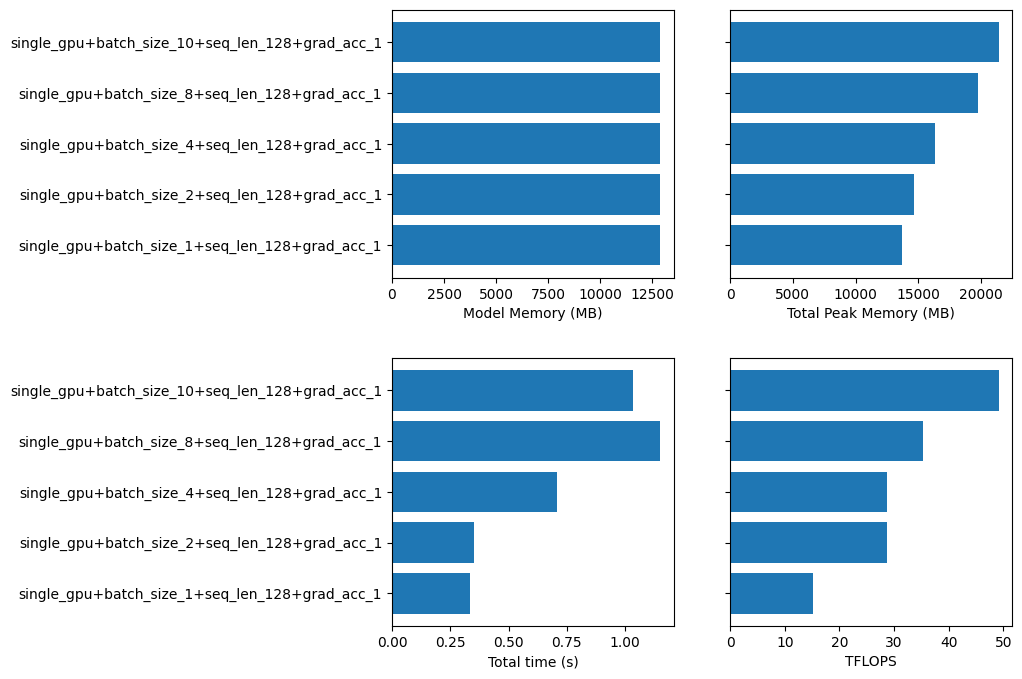

In [38]:
compare_exp(single_gpu_batch_size_exps)

So by using all of the memories, the TFLOPS can reach ~50, ~70% of the maximum TFLOPS. This number is a little bit higher than expected. This is because of the error in timing. However, this number can be a good baseline for further experiments. Let's test the case when we also employ gradient accumulation, such that we can reduce the time cost for the optimizer's update process.

In [40]:
single_gpu_grad_acc_exps = []
for grad_acc in [1, 2, 4, 8, 16]:
    exp_name = f'single_gpu+batch_size_10+seq_len_128+grad_acc_{grad_acc}'
    workspace = WORKSPACE / exp_name
    single_gpu_grad_acc_exps.append(Exp(
        exp_name, str(workspace),
        num_gpus=1,
        gradient_accumulation_steps=grad_acc,
        micro_batch_size=10,
        sequence_length=128,
        use_lora=True))

desc = 'Running experiments for single GPU with gradient accumulation steps'
for exp in tqdm(single_gpu_grad_acc_exps, desc=desc):
    exp.run()
clear_output()

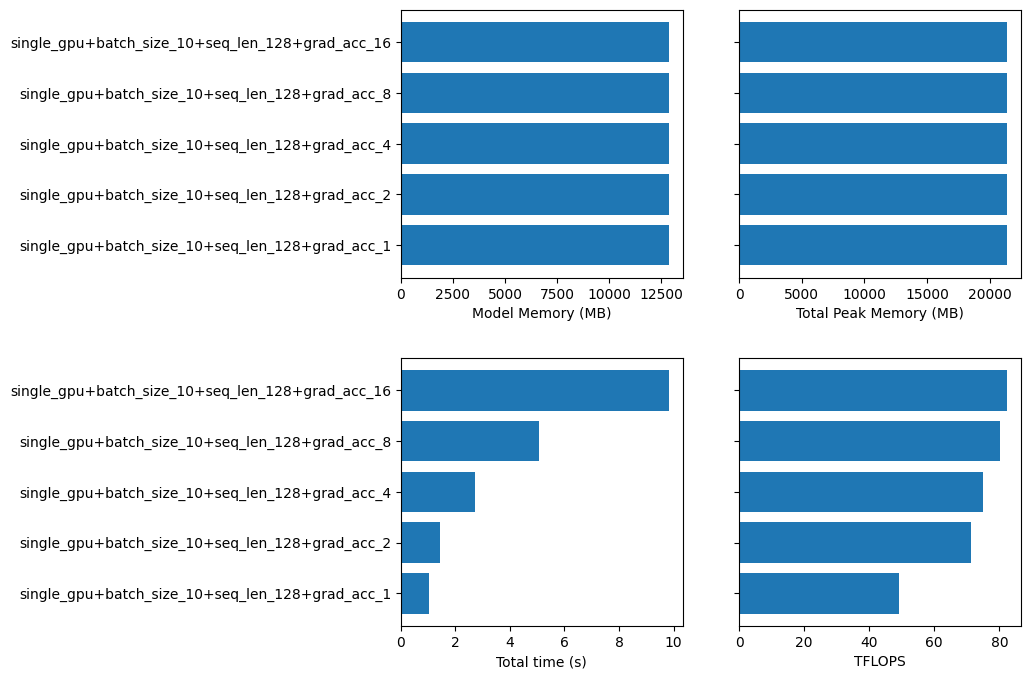

In [41]:
compare_exp(single_gpu_grad_acc_exps)

Therefore, the gradient accumulation can significantly increase the utilization of GPUs (~2x).

In [49]:
single_gpu_seq_len_exps = []
for seq_len in [128, 256, 512, 1024, 2048]:
    exp_name = f'single_gpu+batch_size_2+seq_len_{seq_len}+grad_acc_1'
    workspace = WORKSPACE / exp_name
    single_gpu_seq_len_exps.append(Exp(
        exp_name, str(workspace),
        num_gpus=1,
        gradient_accumulation_steps=1,
        micro_batch_size=2,
        sequence_length=seq_len,
        use_lora=True))

desc = 'Running experiments for single GPU with different sequence lengths'
for exp in tqdm(single_gpu_seq_len_exps, desc=desc):
    exp.run()
clear_output()

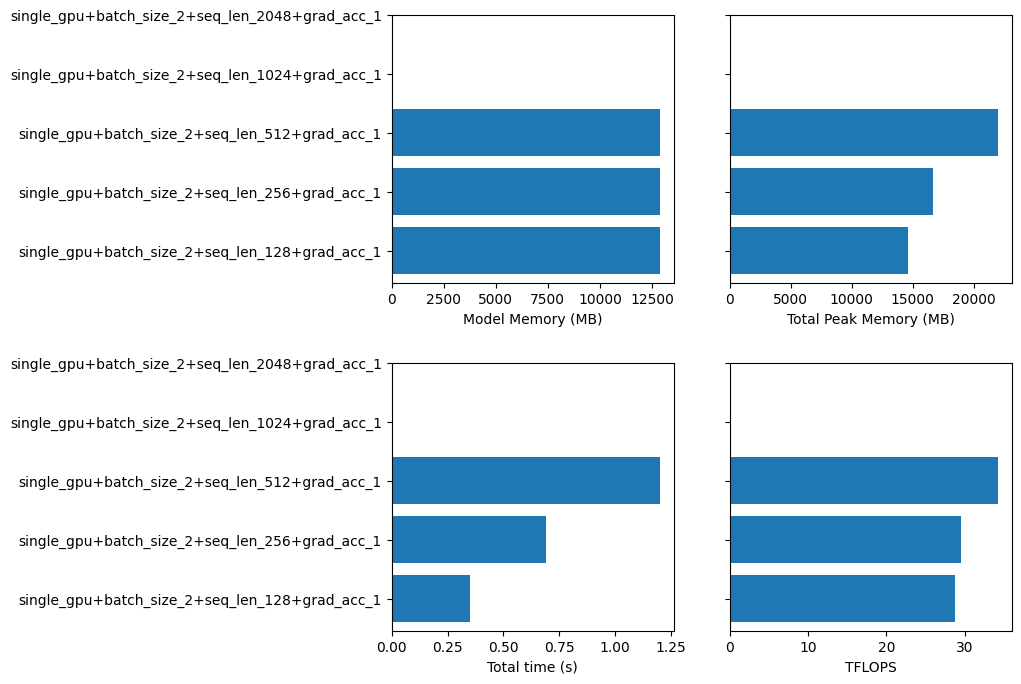

In [50]:
compare_exp(single_gpu_seq_len_exps)

We can see that for longer sequence lengths, the model will hit an OOM error. This is due to the expansion of activation size. We can reduce this by using more GPUs. Now we take a look at FSDP.

In [54]:
gpu_number_exps = []
for gpu_num in [1, 2, 4, 8]:
    if gpu_num == 1:
        gpu_num = 'single'
    exp_name = f'{gpu_num}_gpu+batch_size_8+seq_len_128+grad_acc_1'
    workspace = WORKSPACE / exp_name
    gpu_number_exps.append(Exp(
        exp_name, str(workspace),
        num_gpus=1 if isinstance(gpu_num, str) else gpu_num,
        gradient_accumulation_steps=1,
        micro_batch_size=8,
        sequence_length=128,
        use_lora=True))

desc = 'Running experiments for GPU counts'
for exp in tqdm(gpu_number_exps, desc=desc):
    exp.run()
clear_output()

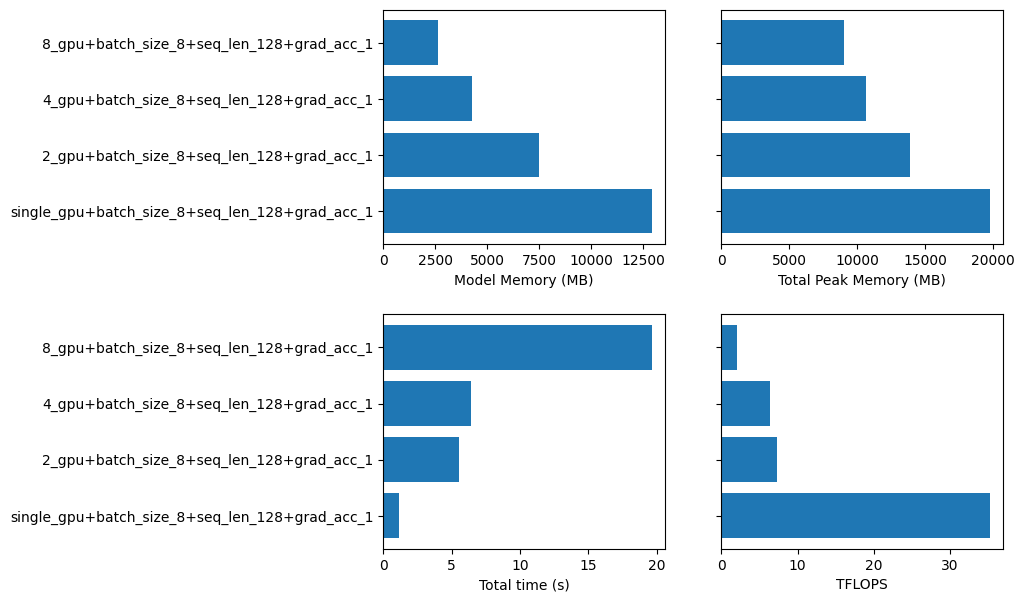

In [52]:
compare_exp(gpu_number_exps)

We can see that by using FSDP, the memory usage is greatyly reduced. However, due to the extra cost for communication, the TFLOPS of the model also decreases dramatically. Luckily, we can enlarge the batch size of the model to achieve better TFLOPS.

In [55]:
multi_gpu_batch_size_exps = []
for batch_size in [8, 16, 32, 64]:
    exp_name = f'8_gpu+batch_size_{batch_size}+seq_len_128+grad_acc_1'
    workspace = WORKSPACE / exp_name
    multi_gpu_batch_size_exps.append(Exp(
        exp_name, str(workspace),
        num_gpus=8,
        gradient_accumulation_steps=1,
        micro_batch_size=batch_size,
        sequence_length=128,
        use_lora=True))

desc = 'Running experiments for multi-GPU batch size'
for exp in tqdm(multi_gpu_batch_size_exps, desc=desc):
    exp.run()
clear_output()

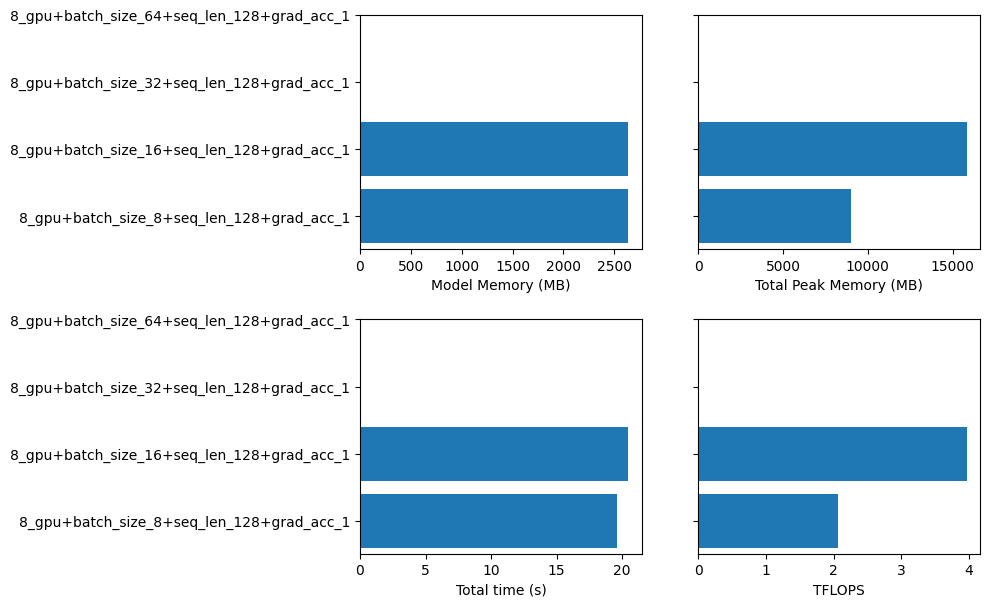

In [56]:
compare_exp(multi_gpu_batch_size_exps)

We can see that the TFLOPS is better, but larger batch size also causes OOM error. We should note that here the sequence length is 128 and the peak memory is not 24GB. This means that we can make better use of the GPU by using a larger token length and a smaller micro batch size.

In [7]:
multi_gpu_seq_len_exps = []
for seq_len in [128, 256, 512, 1024, 2048]:
    exp_name = f'8_gpu+batch_size_4+seq_len_{seq_len}+grad_acc_1'
    workspace = WORKSPACE / exp_name
    multi_gpu_seq_len_exps.append(Exp(
        exp_name, str(workspace),
        num_gpus=8,
        gradient_accumulation_steps=1,
        micro_batch_size=4,
        sequence_length=seq_len,
        use_lora=True))

desc = 'Running experiments for multi-GPU batch size'
for exp in tqdm(multi_gpu_seq_len_exps, desc=desc):
    exp.run()
clear_output()

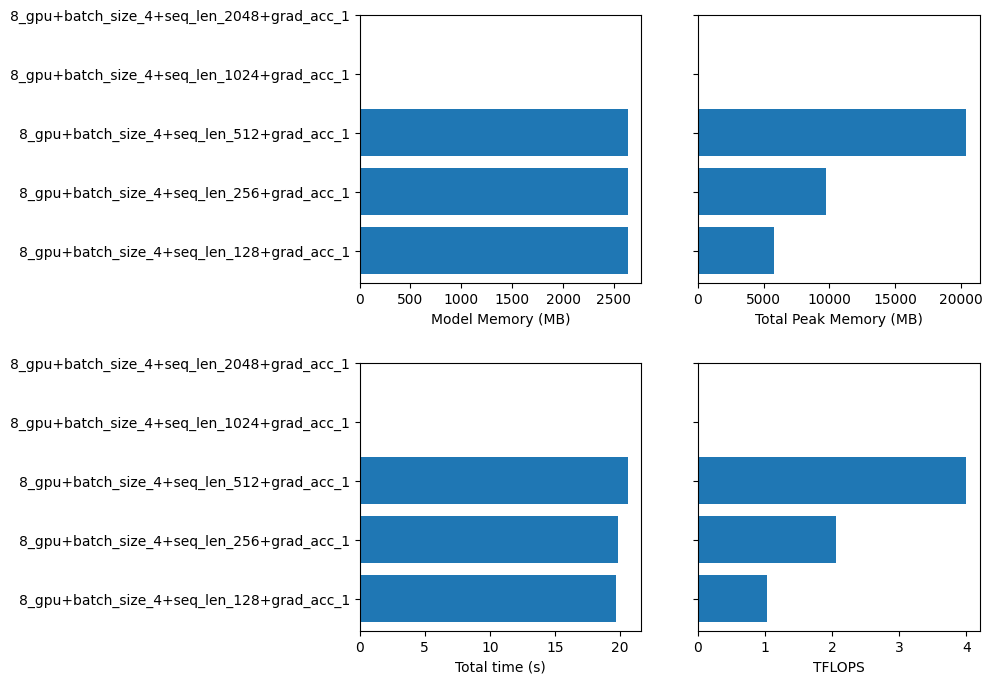

In [8]:
compare_exp(multi_gpu_seq_len_exps)

In [9]:
multi_gpu_grad_acc_exps = []
for grad_acc in [1, 2, 4, 8, 16]:
    exp_name = f'8_gpu+batch_size_4+seq_len_512+grad_acc_{grad_acc}'
    workspace = WORKSPACE / exp_name
    multi_gpu_grad_acc_exps.append(Exp(
        exp_name, str(workspace),
        num_gpus=8,
        gradient_accumulation_steps=grad_acc,
        micro_batch_size=4,
        sequence_length=512,
        use_lora=True))

desc = 'Running experiments for multi-GPU batch size'
for exp in tqdm(multi_gpu_grad_acc_exps, desc=desc):
    exp.run()
clear_output()

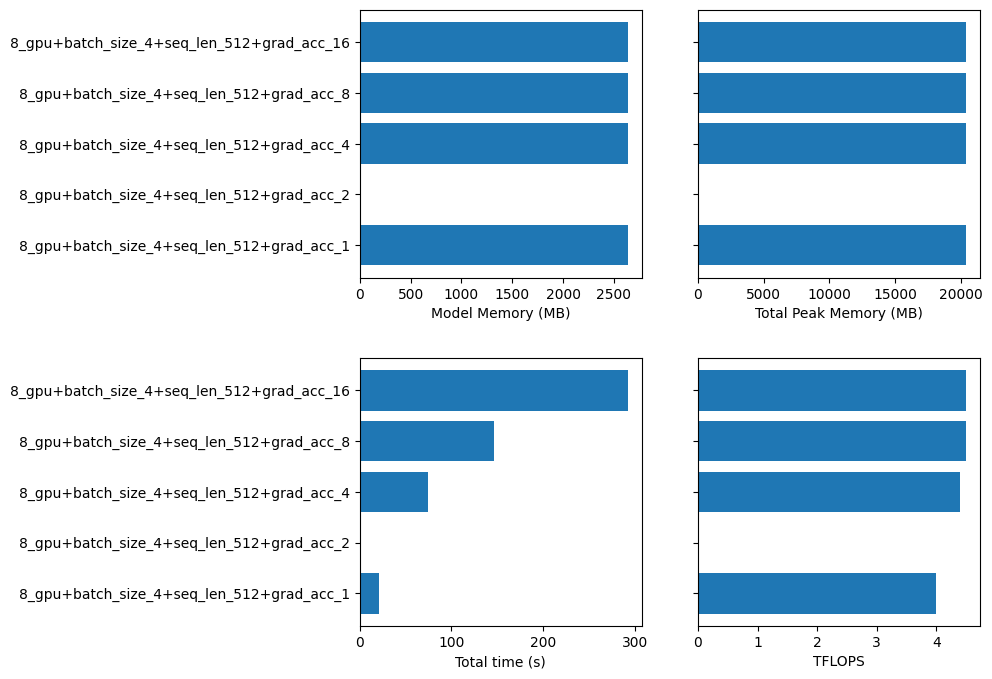

In [10]:
compare_exp(multi_gpu_grad_acc_exps)

In [13]:
multi_gpu_act_ckpt_exps = []
for seq_len in [512, 1024, 2048]:
    exp_name = f'8_gpu+batch_size_2+seq_len_{seq_len}+grad_acc_1+act_ckpt'
    workspace = WORKSPACE / exp_name
    multi_gpu_act_ckpt_exps.append(Exp(
        exp_name, str(workspace),
        num_gpus=8,
        gradient_accumulation_steps=1,
        micro_batch_size=2,
        sequence_length=seq_len,
        use_lora=True,
        activation_checkpoint=True))

desc = 'Running experiments for multi-GPU activation checkpointing'
for exp in tqdm(multi_gpu_act_ckpt_exps, desc=desc):
    exp.run()
clear_output()

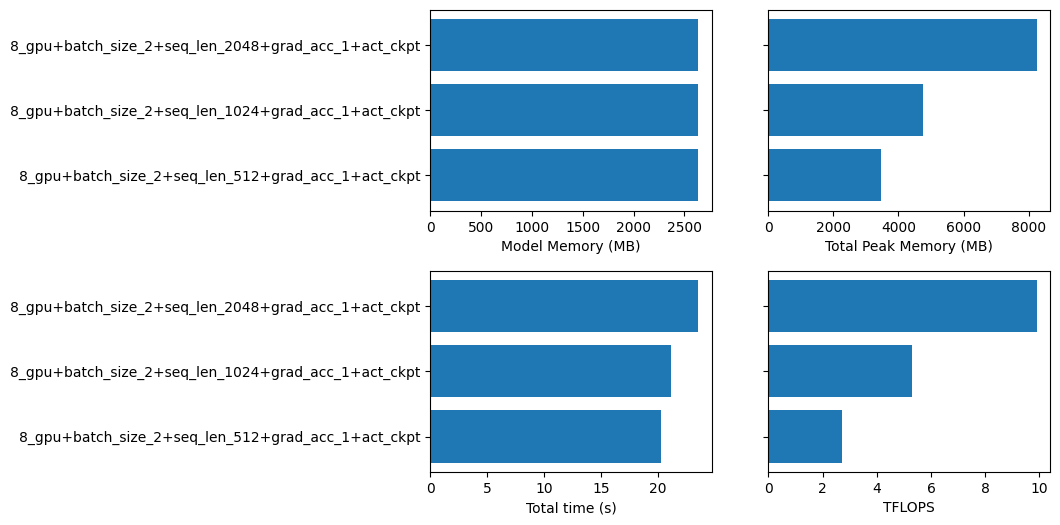

In [14]:
compare_exp(multi_gpu_act_ckpt_exps)

In [18]:
multi_gpu_act_ckpt_exps = []
for seq_len in [2048]:
    exp_name = f'8_gpu+batch_size_5+seq_len_{seq_len}+grad_acc_1+act_ckpt'
    workspace = WORKSPACE / exp_name
    multi_gpu_act_ckpt_exps.append(Exp(
        exp_name, str(workspace),
        num_gpus=8,
        gradient_accumulation_steps=1,
        micro_batch_size=5,
        sequence_length=seq_len,
        use_lora=True,
        activation_checkpoint=True))

desc = 'Running experiments for multi-GPU activation checkpointing'
for exp in tqdm(multi_gpu_act_ckpt_exps, desc=desc):
    exp.run()
# clear_output()

Running experiments for multi-GPU activation checkpointing:   0%|          | 0/1 [00:00<?, ?it/s]

PYTHONPATH=/workspace/test_peft/tour_fsdp/ CUDA_VISIBLE_DEVICES=0,1,2,3,4,5,6,7 torchrun --nproc_per_node 8  /workspace/test_peft/tour_fsdp/main.py workspace/8_gpu+batch_size_5+seq_len_2048+grad_acc_1+act_ckpt --model 7B --gradient-accumulation-steps 1 --micro-batch-size 6 --sequence-length 2048 --use-lora --enable-activation-checkpointing --enable-fsdp


[2023-08-03 05:01:14,003] torch.distributed.run: [WARNING] 
[2023-08-03 05:01:14,003] torch.distributed.run: [WARNING] *****************************************
[2023-08-03 05:01:14,003] torch.distributed.run: [WARNING] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
[2023-08-03 05:01:14,003] torch.distributed.run: [WARNING] *****************************************



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /opt/conda/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues

===================================BUG REPORT===================================
We

Traceback (most recent call last):
  File "/workspace/test_peft/tour_fsdp/main.py", line 215, in <module>
Traceback (most recent call last):
  File "/workspace/test_peft/tour_fsdp/main.py", line 215, in <module>
Traceback (most recent call last):
  File "/workspace/test_peft/tour_fsdp/main.py", line 215, in <module>
Traceback (most recent call last):
  File "/workspace/test_peft/tour_fsdp/main.py", line 215, in <module>
Traceback (most recent call last):
  File "/workspace/test_peft/tour_fsdp/main.py", line 215, in <module>
Traceback (most recent call last):
  File "/workspace/test_peft/tour_fsdp/main.py", line 215, in <module>
Traceback (most recent call last):
  File "/workspace/test_peft/tour_fsdp/main.py", line 215, in <module>
    main(args)
  File "/workspace/test_peft/tour_fsdp/main.py", line 70, in main
    main(args)
  File "/workspace/test_peft/tour_fsdp/main.py", line 70, in main
    main(args)
  File "/workspace/test_peft/tour_fsdp/main.py", line 70, in main
    main(args)


[Errno 2] No such file or directory: 'workspace/8_gpu+batch_size_5+seq_len_2048+grad_acc_1+act_ckpt/log.0'


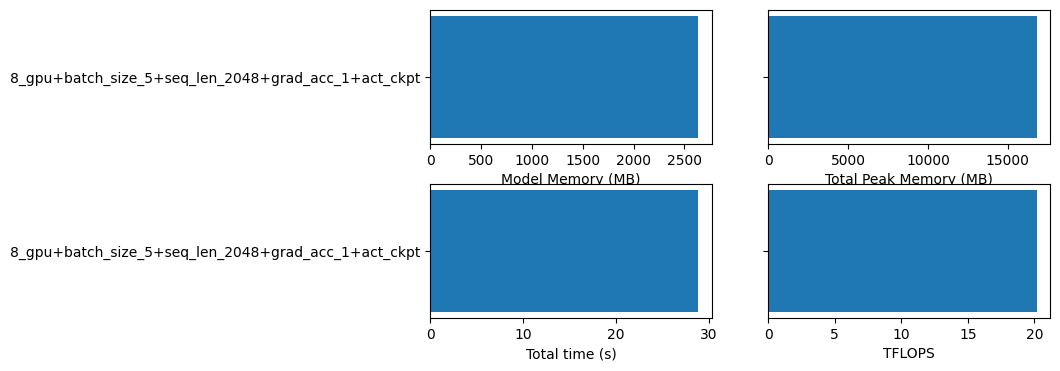

In [17]:
compare_exp(multi_gpu_act_ckpt_exps)